In [ ]:
!pip install pydub
!pip install ffmpeg
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import numpy as np
from pydub import AudioSegment
import librosa
import IPython.display as ipd
import tensorflow as tf
import pandas as pd
import os
import wave
import pylab
import sys
sys.path.insert(0, '/content/drive/MyDrive/Datasets/SoundRecog/Natural_Sound_Dataset/dataset1/')
import IPython.display as ipd

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras import layers, models, activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import train_test_split

import librosa
from pathlib import Path

In [ ]:
audioCSV = pd.read_csv('/content/drive/MyDrive/Datasets/SoundRecog/Natural_Sound_Dataset/AudioTrainingDataSet/AudioTrainingSheet.csv')

In [ ]:
audioCSV.shape

(3236, 7)

In [ ]:

#All training data directories
DIRECTORIES = ['/content/drive/MyDrive/Datasets/SoundRecog/Natural_Sound_Dataset/dataset1/audio/audio/44100/',
                '/content/drive/MyDrive/Datasets/SoundRecog/Natural_Sound_Dataset/AudioTrainingDataSet/audiofiles/cadillac',
                '/content/drive/MyDrive/Datasets/SoundRecog/Natural_Sound_Dataset/AudioTrainingDataSet/audiofiles/pinehill',
                '/content/drive/MyDrive/Datasets/SoundRecog/Natural_Sound_Dataset/AudioTrainingDataSet/audiofiles/bernard',
                '/content/drive/MyDrive/Datasets/SoundRecog/Natural_Sound_Dataset/AudioTrainingDataSet/audiofiles/gilmore',
                '/content/drive/MyDrive/Datasets/SoundRecog/Natural_Sound_Dataset/AudioTrainingDataSet/audiofiles/northeast']

#Acadia only training data directories
ACAD_DIRECTORIES = ['/content/drive/MyDrive/Datasets/SoundRecog/Natural_Sound_Dataset/AudioTrainingDataSet/audiofiles/cadillac',
                '/content/drive/MyDrive/Datasets/SoundRecog/Natural_Sound_Dataset/AudioTrainingDataSet/audiofiles/pinehill',
                '/content/drive/MyDrive/Datasets/SoundRecog/Natural_Sound_Dataset/AudioTrainingDataSet/audiofiles/bernard',
                '/content/drive/MyDrive/Datasets/SoundRecog/Natural_Sound_Dataset/AudioTrainingDataSet/audiofiles/gilmore',
                '/content/drive/MyDrive/Datasets/SoundRecog/Natural_Sound_Dataset/AudioTrainingDataSet/audiofiles/northeast']


#location of spectrograms
OUTPUT_DIR = '/content/drive/MyDrive/Datasets/Spectrograms/'

#folder name for all training images
SPEC_DIR = 'nat-unat-audio-images'

#Folder name for acadia only images
ACAD_DIR = 'acadia-only-audio-images'

In [ ]:
#where to define each category as natural or unnatural
natural_sounds = [23, 5, 14, 3, 13, 9, 0, 30, 29, 25,  4,
                  6, 7, 2, 17, 10, 1, 11, 8, 21, 19,
                  15, 16, 51]
unnatural_sounds= [47, 27, 34, 43, 41, 46, 22, 37,
                   38, 24, 12, 20, 33, 44, 48, 39,
                   49, 40, 32, 26, 31, 42, 28, 18, 45,
                   36, 35]

In [ ]:
print(len(natural_sounds))
print(len(unnatural_sounds))


24
27


In [ ]:

#helper for determineing if a category is a natural or unnatural
def Natural_Definer(target):
  if target in natural_sounds:
    return 0
  elif target in unnatural_sounds:
    return 1
  else:
    return 2

#helper for gettign audio samples and sample rate from wav file path
def get_wav_info(wav_file):
  """
  wav = wave.open(wav_file, 'r')
  frames = wav.readframes(-1)
  sound_info = pylab.frombuffer(frames, 'int16')
  frame_rate = wav.getframerate()
  wav.close()
  """
  sound_info, frame_rate = librosa.load(wav_file)
  return sound_info, frame_rate

In [ ]:
# Utility function to get sound and frame rate info

# For every recording, make a spectogram and save it as label_speaker_no.png
if not os.path.exists(os.path.join(OUTPUT_DIR, ACAD_DIR)):
    os.mkdir(os.path.join(OUTPUT_DIR, ACAD_DIR))



for INPUT_DIR in ACAD_DIRECTORIES:
  for filename in os.listdir(INPUT_DIR):
      if "wav" in filename:
          file_path = os.path.join(INPUT_DIR, filename)
          file_stem = Path(file_path).stem
          target_dir = f"class_{Natural_Definer(int(filename.split('.')[0].split('-')[3]))}"
          dist_dir = os.path.join(os.path.join(OUTPUT_DIR, ACAD_DIR), target_dir)
          file_dist_path = os.path.join(dist_dir, file_stem)
          if not os.path.exists(file_dist_path + '.png'):
              if not os.path.exists(dist_dir):
                  os.mkdir(dist_dir)
              file_stem = Path(file_path).stem
              sound_info, frame_rate = get_wav_info(file_path)
              #In order to change how spectrograms are made experiment with the pylab function below as this is where the image is made
              pylab.specgram(sound_info, Fs=frame_rate)
              pylab.savefig(f'{file_dist_path}.png')
              pylab.close()




/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:7773: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


In [ ]:
#should have 2 class 0 and 1 if everything is right
path_list = os.listdir(os.path.join(OUTPUT_DIR, SPEC_DIR))
print("Classes: \n")
for i in range(2):
    print(path_list[i])

Classes: 

class_1
class_0


In [ ]:
# Declare constants
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 32
N_CHANNELS = 3
N_CLASSES = 2

# Make a dataset containing the training spectrograms
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=os.path.join(OUTPUT_DIR, ACAD_DIR),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="training",
                                             seed=0)

# Make a dataset containing the validation spectrogram
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=os.path.join(OUTPUT_DIR, ACAD_DIR),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="validation",
                                             seed=0)

Found 1234 files belonging to 2 classes.
Using 988 files for training.
Found 1234 files belonging to 2 classes.
Using 246 files for validation.


In [ ]:
#model architecture, wouldn't touch
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))

model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))

model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))

model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))

model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                        

In [ ]:
# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=['accuracy'],
)


In [ ]:
# Train model, capture the history
history = model.fit(train_dataset, epochs=50, validation_data=valid_dataset)

Epoch 1/50
31/31 [==============================] - 62s 1s/step - loss: 0.5127 - accuracy: 0.7925 - val_loss: 3.0390 - val_accuracy: 0.5244
Epoch 2/50
31/31 [==============================] - 10s 265ms/step - loss: 0.3338 - accuracy: 0.8725 - val_loss: 1.1350 - val_accuracy: 0.5894
Epoch 3/50
31/31 [==============================] - 10s 226ms/step - loss: 0.2849 - accuracy: 0.8917 - val_loss: 0.3893 - val_accuracy: 0.7805
Epoch 4/50
31/31 [==============================] - 11s 271ms/step - loss: 0.2496 - accuracy: 0.9119 - val_loss: 0.6716 - val_accuracy: 0.7683
Epoch 5/50
31/31 [==============================] - 10s 275ms/step - loss: 0.2383 - accuracy: 0.9170 - val_loss: 0.2483 - val_accuracy: 0.9228
Epoch 6/50
31/31 [==============================] - 8s 223ms/step - loss: 0.2052 - accuracy: 0.9291 - val_loss: 0.8809 - val_accuracy: 0.6667
Epoch 7/50
31/31 [==============================] - 11s 272ms/step - loss: 0.2034 - accuracy: 0.9221 - val_loss: 0.3542 - val_accuracy: 0.8455
Epo

In [ ]:
#uncomment and save model if desired
#model.save('/content/drive/MyDrive/Datasets/IQPModels/BinaryModelAcc92.h5')

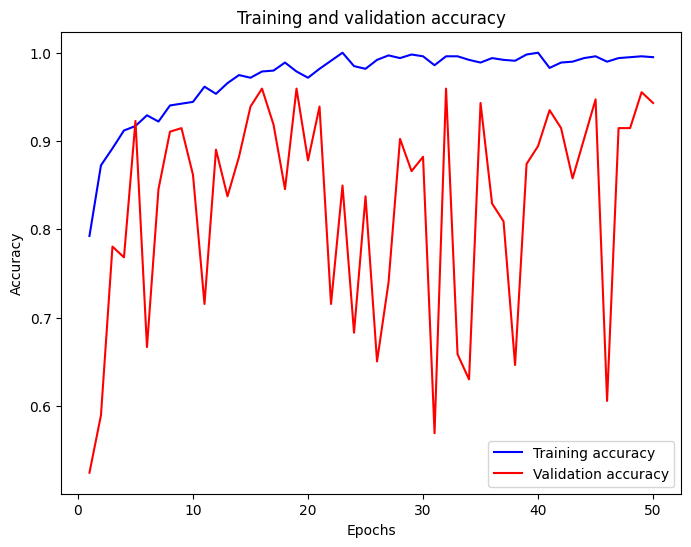

In [ ]:
# Plot the accuracy curves for training and validation.
history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values,  color='blue', label='Training accuracy')
plt.plot(epochs, val_acc_values, color='red', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

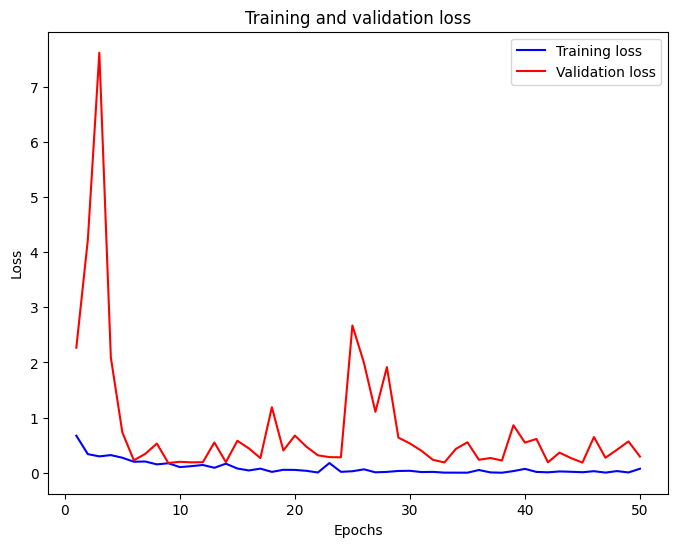

In [ ]:
# Plot the accuracy curves for training and validation.
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

ax = plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, color='blue', label='Training loss')
plt.plot(epochs, val_loss_values, color='red', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#helper functions for testing new model
def NumericalPrediction(tensorPrediction):
  return np.argmax(tensorPrediction[0])

def LabelLookUp(label):
  row = audioCSV.loc[audioCSV['target'] == label]
  return row['category'].unique()[0]

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH])

def path_to_img(path):
  img = tf.io.read_file(path)
  img = decode_img(img)
  return img

1/1 [==============================] - 0s 22ms/step


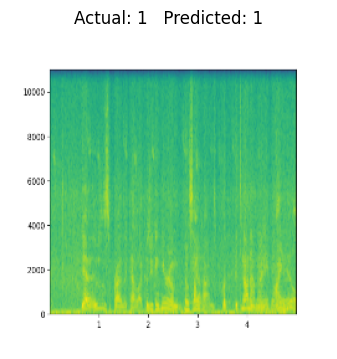

In [ ]:
#DEMO FROM VALID SET
sample = valid_dataset.unbatch().take(1)

plt.figure(figsize=(14, 14))

for image, label in sample:
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image.numpy().astype("uint8"))

  #takes image and runs it through a prediction
  x = np.expand_dims(image, axis=0)
  y_predict = model.predict(x)

  plt.title("Actual: "+ str(label.numpy().astype("uint8")) + "   Predicted: " + str(NumericalPrediction(y_predict)))
  plt.axis("off")
plt.show()

In [ ]:
#load audio files unri
esc_50_audio = os.listdir(DIRECTORIES[0])
print('esc50 has ' + str(len(esc_50_audio)) + ' samples')
cadillac_audio = os.listdir(DIRECTORIES[1])
print('cadillac has ' + str(len(cadillac_audio)) + ' samples')
pinehill_audio = os.listdir(DIRECTORIES[2])
print('pinehill has ' + str(len(pinehill_audio)) + ' samples')
bernard_audio = os.listdir(DIRECTORIES[3])
print('bernard has ' + str(len(bernard_audio)) + ' samples')
gilmore_audio = os.listdir(DIRECTORIES[4])
print('gilmore has ' + str(len(gilmore_audio)) + ' samples')
northeast_audio = os.listdir(DIRECTORIES[5])
print('northeast has ' + str(len(northeast_audio)) + ' samples')


esc50 has 2000 samples
cadillac has 122 samples
pinehill has 113 samples
bernard has 268 samples
gilmore has 171 samples
northeast has 0 samples


7-0701040230-I-10.wav
0


/content/drive/MyDrive/Datasets/Spectrograms/nat-unat-audio-images/class_0/7-0701040230-I-10.png


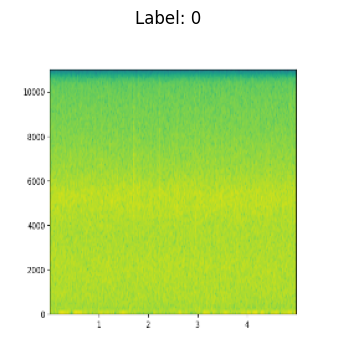

In [ ]:
#DEMO with Sound from data set

#52 plane
#47 bird

wavAudioNum = 23
wavName = pinehill_audio[wavAudioNum]

print(wavName)
print(Natural_Definer(int(wavName.split('.')[0].split('-')[3])))
filepath = DIRECTORIES[2] + '/' + wavName
samples, sample_rate = librosa.load(filepath)
frequencies, times, spectrogram = signal.spectrogram(samples, fs=sample_rate)

ipd.display(ipd.Audio(samples, rate=sample_rate))
imagepng = OUTPUT_DIR + SPEC_DIR + '/class_' + str(Natural_Definer(int(wavName.split('.')[0].split('-')[3]))) + '/' + wavName.split('.')[0] + '.png'
print(imagepng)

img = path_to_img(imagepng)
plt.figure(figsize=(14, 14))
ax = plt.subplot(3, 3, i + 1)
plt.imshow(img.numpy().astype("uint8"))
#takes image and runs it through a prediction
x = np.expand_dims(img, axis=0)
#y_predict = model.predict(x)
plt.title("Label: " + str(Natural_Definer(int(wavName.split('.')[0].split('-')[3]))))
plt.axis("off")
plt.show()


In [ ]:
#Show model prediction
img = path_to_img(imagepng)
x = np.expand_dims(img, axis=0)
y_predict = model.predict(x)
print(y_predict[0])

print('Guess: ' + str(NumericalPrediction(y_predict)))


1/1 [==============================] - 0s 19ms/step
[1.0000000e+00 1.7552701e-10]
Guess: 0
